In [1]:
# Core Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm import tqdm
from collections import Counter
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB3

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Deep Learning
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

print("✅ All necessary libraries imported.")


✅ All necessary libraries imported.


In [2]:
df = pd.read_csv("HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [4]:
df.isnull().sum()


lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [5]:
df['age'] = df['age'].fillna(df['age'].median())

In [6]:
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64


In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode disease labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['dx'])

# Save label names for future reference
class_names = le.classes_
print("Disease classes:", class_names)


Disease classes: ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


In [8]:
import os

# Function to get image path from two folders
def get_full_image_path(image_id):
    path1 = f"HAM10000_images_part_1/{image_id}.jpg"
    path2 = f"HAM10000_images_part_2/{image_id}.jpg"
    
    # Check both paths
    if os.path.exists(path1):
        return path1
    elif os.path.exists(path2):
        return path2
    else:
        return None  # If image is missing

# Apply the function to create image paths
df["image_path"] = df["image_id"].apply(get_full_image_path)

# Check if there are any missing paths
missing_images = df["image_path"].isnull().sum()
print(f"Missing images: {missing_images}")


Missing images: 0


In [9]:
df[["image_id", "image_path", "dx", "label"]].head()


,image_id,image_path,dx,label
0,ISIC_0027419,HAM10000_images_part_1/ISIC_0027419.jpg,bkl,2
1,ISIC_0025030,HAM10000_images_part_1/ISIC_0025030.jpg,bkl,2
2,ISIC_0026769,HAM10000_images_part_1/ISIC_0026769.jpg,bkl,2
3,ISIC_0025661,HAM10000_images_part_1/ISIC_0025661.jpg,bkl,2
4,ISIC_0031633,HAM10000_images_part_2/ISIC_0031633.jpg,bkl,2


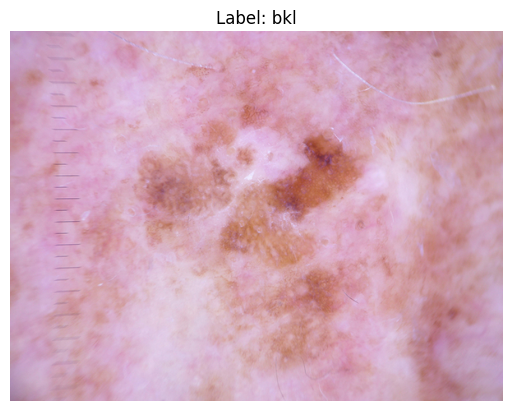

In [10]:
index = 0

# Get image path
image_path = df.loc[index, 'image_path']
label = df.loc[index, 'dx']  # disease name

# Read and display image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display

plt.imshow(img)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

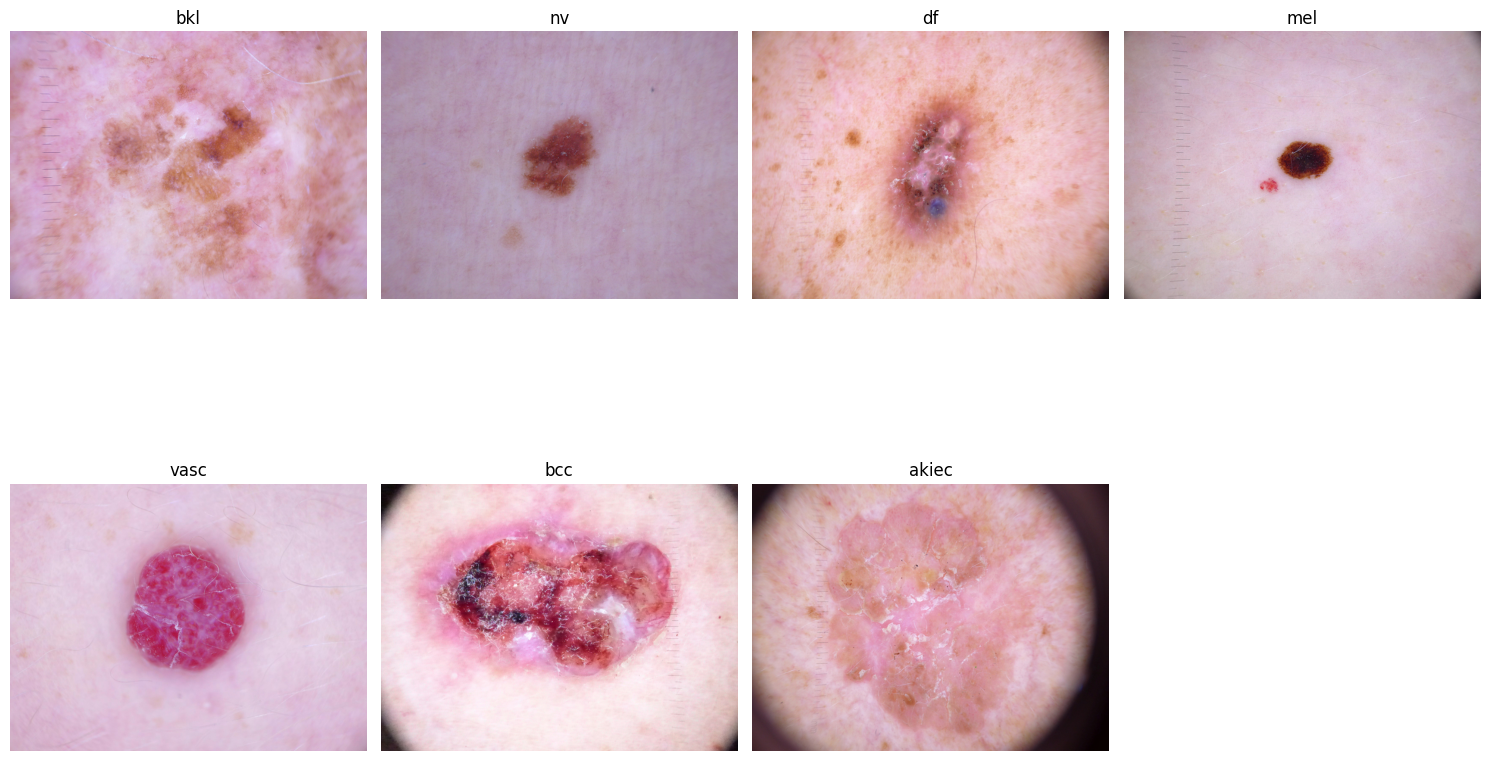

In [11]:
# akiec – Actinic keratoses
# bcc – Basal cell carcinoma
# bkl – Benign keratosis-like lesions
# df – Dermatofibroma
# mel – Melanoma
# nv – Melanocytic nevi
# vasc – Vascular lesions

unique_classes = df['dx'].unique()

# Plot one image per class
plt.figure(figsize=(15, 10))

for i, disease in enumerate(unique_classes):
    # Get the first image of that class
    row = df[df['dx'] == disease].iloc[0]
    img_path = row['image_path']
    
    # Read and convert image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Show subplot
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(disease)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Count number of images per class
class_counts = df['dx'].value_counts()

print(class_counts)


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


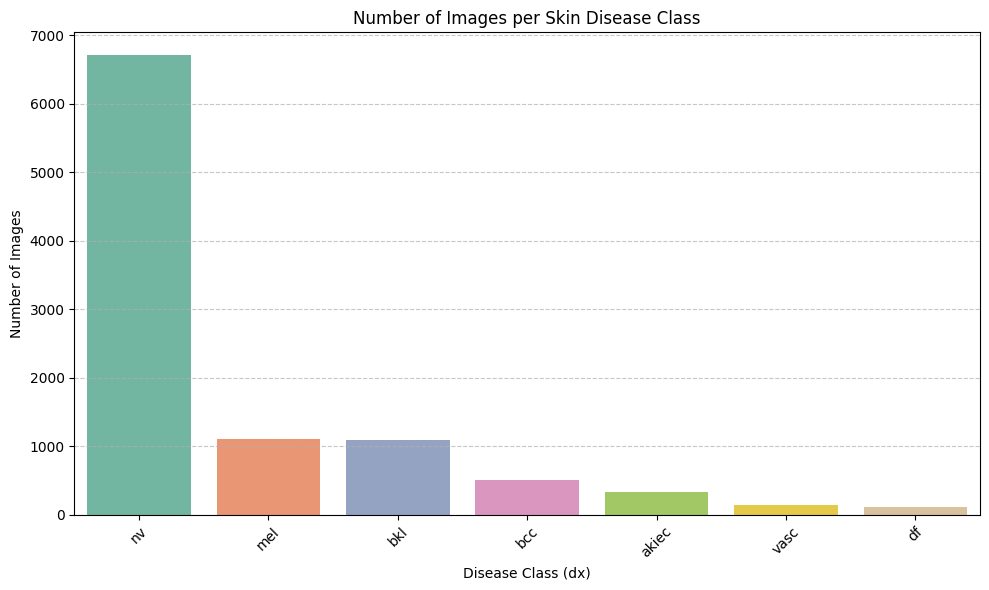

In [13]:
class_df = class_counts.reset_index()
class_df.columns = ['dx', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(data=class_df, x='dx', y='count', hue='dx', palette="Set2", dodge=False, legend=False)
plt.title("Number of Images per Skin Disease Class")
plt.xlabel("Disease Class (dx)")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [14]:
# # Define target classes needing augmentation
# underrepresented_classes = ['df', 'vasc', 'akiec', 'bcc']

# # Output folder for augmented images
# augmented_dir = "augmented_images"
# os.makedirs(augmented_dir, exist_ok=True)

# # Define image augmentor
# datagen = ImageDataGenerator(
#     rotation_range=30,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     vertical_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     fill_mode='nearest'
# )

# # Resize shape expected by CNNs
# IMG_SIZE = 224  # Can use 224 for MobileNet, ResNet, etc.

In [15]:
import os
import cv2
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# === CONFIG ===
IMG_SIZE = 224
CLASS_TARGETS = {
    'nv': 3500,
    'bkl': 3500,
    'df': 5000,
    'mel': 3500,
    'vasc': 5000,
    'bcc': 3500,
    'akiec': 5500
}
augmented_dir = "augmented_classwise"
os.makedirs(augmented_dir, exist_ok=True)

# === Load your DataFrame (already prepared) ===
# df = pd.read_csv("your_dataframe.csv")  # Make sure 'image_path' and 'dx' columns are present

# === Define the augmentation generator ===
datagen = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# === AUGMENTATION PROCESS ===
for cls, target_count in CLASS_TARGETS.items():
    cls_df = df[df['dx'] == cls]
    current_count = len(cls_df)
    to_generate = target_count - current_count

    if to_generate <= 0:
        print(f"✅ '{cls}' already has {current_count} images.")
        continue

    print(f"\n🔁 Augmenting '{cls}' from {current_count} to {target_count} images...")

    saved = 0
    index = 0
    while saved < to_generate:
        row = cls_df.iloc[index % current_count]
        img_path = row['image_path']

        if not os.path.exists(img_path):
            index += 1
            continue

        img = cv2.imread(img_path)
        if img is None:
            index += 1
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = np.expand_dims(img, axis=0)

        # Generate and save
        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)
        save_name = f"{cls}_aug_{saved}.jpg"
        save_path = os.path.join(augmented_dir, save_name)
        cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

        saved += 1
        index += 1

    print(f"✅ Done: {saved} augmented images saved for '{cls}'.")

print("\n🎉 All underrepresented classes augmented successfully.")


✅ 'nv' already has 6705 images.

🔁 Augmenting 'bkl' from 1099 to 3500 images...
✅ Done: 2401 augmented images saved for 'bkl'.

🔁 Augmenting 'df' from 115 to 5000 images...
✅ Done: 4885 augmented images saved for 'df'.

🔁 Augmenting 'mel' from 1113 to 3500 images...
✅ Done: 2387 augmented images saved for 'mel'.

🔁 Augmenting 'vasc' from 142 to 5000 images...
✅ Done: 4858 augmented images saved for 'vasc'.

🔁 Augmenting 'bcc' from 514 to 3500 images...
✅ Done: 2986 augmented images saved for 'bcc'.

🔁 Augmenting 'akiec' from 327 to 5500 images...
✅ Done: 5173 augmented images saved for 'akiec'.

🎉 All underrepresented classes augmented successfully.


In [16]:
from collections import Counter
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Build DataFrame from augmented images
augmented_files = [f for f in os.listdir(augmented_dir) if f.endswith(".jpg")]
augmented_data = []

for file in augmented_files:
    label = file.split("_aug_")[0]  # Extract label
    path = os.path.join(augmented_dir, file)
    augmented_data.append({"image_path": path, "dx": label})

augmented_df = pd.DataFrame(augmented_data)

# Step 2: Combine original + augmented
combined_df = pd.concat([df[["image_path", "dx"]], augmented_df], ignore_index=True)

# Step 3: Rename dx → label
combined_df = combined_df.rename(columns={"dx": "label"})

# Step 4: Make labels string type
combined_df["label"] = combined_df["label"].astype(str)

# ✅ Step 5: Check original + augmented count (final check)
original_counts = df["dx"].value_counts().to_dict()
aug_counts = Counter([file.split("_aug_")[0] for file in augmented_files])
total_counts = original_counts.copy()
for cls, count in aug_counts.items():
    total_counts[cls] = total_counts.get(cls, 0) + count

print("\n✅ Total image counts (original + augmented):\n", total_counts)
print("\n✅ Distribution in combined_df:\n", combined_df["label"].value_counts())

# Step 6: Filter rare labels (optional if none <2)
valid_labels = combined_df["label"].value_counts()[combined_df["label"].value_counts() >= 2].index
combined_df = combined_df[combined_df["label"].isin(valid_labels)].reset_index(drop=True)

# Step 7: Encode
le = LabelEncoder()
combined_df["label"] = le.fit_transform(combined_df["label"])

# Final check
print("📊 Label distribution after encoding:\n", combined_df["label"].value_counts())
print("🧬 Unique encoded labels:", combined_df["label"].unique())



✅ Total image counts (original + augmented):
 {'nv': 6705, 'mel': 3500, 'bkl': 3500, 'bcc': 3500, 'akiec': 5500, 'vasc': 5000, 'df': 5000}

✅ Distribution in combined_df:
 label
nv       6705
akiec    5500
df       5000
vasc     5000
bkl      3500
mel      3500
bcc      3500
Name: count, dtype: int64
📊 Label distribution after encoding:
 label
5    6705
0    5500
3    5000
6    5000
2    3500
4    3500
1    3500
Name: count, dtype: int64
🧬 Unique encoded labels: [2 5 3 4 6 1 0]


In [17]:
# List of new augmented files
augmented_files = os.listdir(augmented_dir)

# Build new dataframe
augmented_data = []

for file in augmented_files:
    label = file.split("_aug_")[0]  # Extract class from filename
    path = os.path.join(augmented_dir, file)
    augmented_data.append({"image_path": path, "dx": label})

augmented_df = pd.DataFrame(augmented_data)

In [18]:
# Combine with original data
combined_df = pd.concat([df[["image_path", "dx"]], augmented_df], ignore_index=True)

# Check class balance now
print("✅ New Class Distribution:\n", combined_df["dx"].value_counts())

✅ New Class Distribution:
 dx
nv       6705
akiec    5500
df       5000
vasc     5000
bkl      3500
mel      3500
bcc      3500
Name: count, dtype: int64


In [19]:
original_counts = df['dx'].value_counts()
print("Original image counts:\n", original_counts)


Original image counts:
 dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [20]:
from collections import Counter
import os

aug_dir = "augmented_images"
aug_files = [f for f in os.listdir(aug_dir) if f.endswith(".jpg")]

# ✅ Robust extraction of class labels from filenames like 'bcc_aug_1.jpg'
aug_labels = [fname.split("_aug_")[0] for fname in aug_files]

# ✅ Count class-wise augmented images
aug_counts = Counter(aug_labels)
print("\n📦 Augmented image counts per class:\n", aug_counts)



📦 Augmented image counts per class:
 Counter({'df': 1885, 'vasc': 1858, 'akiec': 1673, 'bcc': 1486, 'bkl': 901, 'mel': 887})


In [21]:
# Ensure original_counts is a dict (you can convert from Series)
original_counts = df['dx'].value_counts().to_dict()

# ✅ Combine counts
total_counts = original_counts.copy()
for cls, count in aug_counts.items():
    total_counts[cls] = total_counts.get(cls, 0) + count

print("\n🔢 Total image counts (original + augmented):\n", total_counts)



🔢 Total image counts (original + augmented):
 {'nv': 6705, 'mel': 2000, 'bkl': 2000, 'bcc': 2000, 'akiec': 2000, 'vasc': 2000, 'df': 2000}


In [22]:
augmented_folder = "augmented_images"
if os.path.exists(augmented_folder):
    for root, dirs, files in os.walk(augmented_folder):
        for file in files:
            if file.endswith(".jpg"):
                label = file.split("_")[0]  # e.g. "bcc_1.jpg"
                df = pd.concat([df, pd.DataFrame({
                    'image_id': [file.replace(".jpg", "")],
                    'dx': [label],
                    'image_path': [os.path.join(root, file)]
                })], ignore_index=True)

In [23]:
# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['dx'])
labels = to_categorical(df['label'])

In [24]:
# Rename for consistency
combined_df = combined_df.rename(columns={"dx": "label"})

# Make sure all labels are strings (important for ImageDataGenerator with sparse mode)
combined_df["label"] = combined_df["label"].astype(str)

In [25]:
from sklearn.preprocessing import LabelEncoder

# 🧹 Step 1: Remove rare classes (with <2 samples)
label_counts = combined_df['label'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
combined_df = combined_df[combined_df['label'].isin(valid_labels)].reset_index(drop=True)

# 🔄 Step 2: Apply Label Encoding only after cleaning
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])

# ✅ Optional: Confirm label distribution
print("Label distribution after encoding:\n", combined_df['label'].value_counts())
print("Unique labels:", combined_df['label'].unique())


Label distribution after encoding:
 label
5    6705
0    5500
3    5000
6    5000
2    3500
4    3500
1    3500
Name: count, dtype: int64
Unique labels: [2 5 3 4 6 1 0]


In [21]:
# === 7. PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32

# ✅ REMOVE RARE CLASSES BEFORE ENCODING
# Count each class
label_counts = combined_df['label'].value_counts()

# Filter out classes with less than 2 samples (if needed)
valid_labels = label_counts[label_counts >= 2].index
combined_df = combined_df[combined_df['label'].isin(valid_labels)].reset_index(drop=True)

# ✅ NOW Encode Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])

# ✅ Stratified Split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

# ✅ Convert labels to strings for ImageDataGenerator with class_mode='sparse'
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# === 8. DATA GENERATORS ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'  # ⬅️ Use 'raw' instead of 'sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # ⬅️ Use 'raw' instead of 'sparse'
    shuffle=False
)



Found 23364 validated image filenames belonging to 7 classes.
Found 5841 validated image filenames belonging to 7 classes.


In [26]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Encode string labels into integers
le = LabelEncoder()
train_df['label'] = le.fit_transform(train_df['label'])
test_df['label'] = le.transform(test_df['label'])  # keep it consistent

# Compute class weights using integer labels
classes = np.unique(train_df['label'])
weights = compute_class_weight(class_weight='balanced', classes=classes, y=train_df['label'])

# Final class weight dictionary
class_weights = dict(zip(classes, weights))

print("📊 Class Weights:", class_weights)


NameError: name 'train_df' is not defined

In [23]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import DenseNet121
# === 9. Re-encode Labels ===
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])

# Split again if needed
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

# === 9.1 Class Weights ===
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))


# === 10. Model: DenseNet121 ===
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze early layers
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


# === 11. Compile ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # smaller LR for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === 12. Callbacks ===
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
]

# === 13. Train ===
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights
)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model.h5',              # File to save model to
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Only save best model (not every epoch)
    mode='max',                   # Higher val_accuracy = better
    verbose=1
)

C:\Users\Asus\anaconda3\envs\ham10000_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 951s 1s/step - accuracy: 0.3519 - loss: 1.9182 - val_accuracy: 0.6775 - val_loss: 0.8759 - learning_rate: 1.0000e-04
Epoch 2/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 909s 1s/step - accuracy: 0.6248 - loss: 1.0964 - val_accuracy: 0.7757 - val_loss: 0.6319 - learning_rate: 1.0000e-04
Epoch 3/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 914s 1s/step - accuracy: 0.7055 - loss: 0.8724 - val_accuracy: 0.8060 - val_loss: 0.5376 - learning_rate: 1.0000e-04
Epoch 4/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 917s 1s/step - accuracy: 0.7522 - loss: 0.7430 - val_accuracy: 0.8237 - val_loss: 0.4693 - learning_rate: 1.0000e-04
Epoch 5/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 922s 1s/step - accuracy: 0.7909 - loss: 0.6316 - val_accuracy: 0.8519 - val_loss: 0.4097 - learning_rate: 1.0000e-04
Epoch 6/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 923s 1s/step - accuracy: 0.8077 - loss: 0.5626 - val_accuracy: 0.8615 - val_loss: 0.3752 - learning_rate: 1.0000e-04
Epoch 7/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 964s 1s/step - acc

183/183 ━━━━━━━━━━━━━━━━━━━━ 185s 996ms/step
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97       900
           1       0.95      0.94      0.95       600
           2       0.84      0.85      0.84       600
           3       0.99      1.00      1.00       900
           4       0.80      0.81      0.80       600
           5       0.92      0.92      0.92      1341
           6       1.00      1.00      1.00       900

    accuracy                           0.93      5841
   macro avg       0.93      0.93      0.93      5841
weighted avg       0.93      0.93      0.93      5841

✅ Overall Accuracy: 0.9341
📌 Per-Class Accuracy:
  0: 0.9522
  1: 0.9450
  2: 0.8500
  3: 0.9967
  4: 0.8117
  5: 0.9232
  6: 1.0000


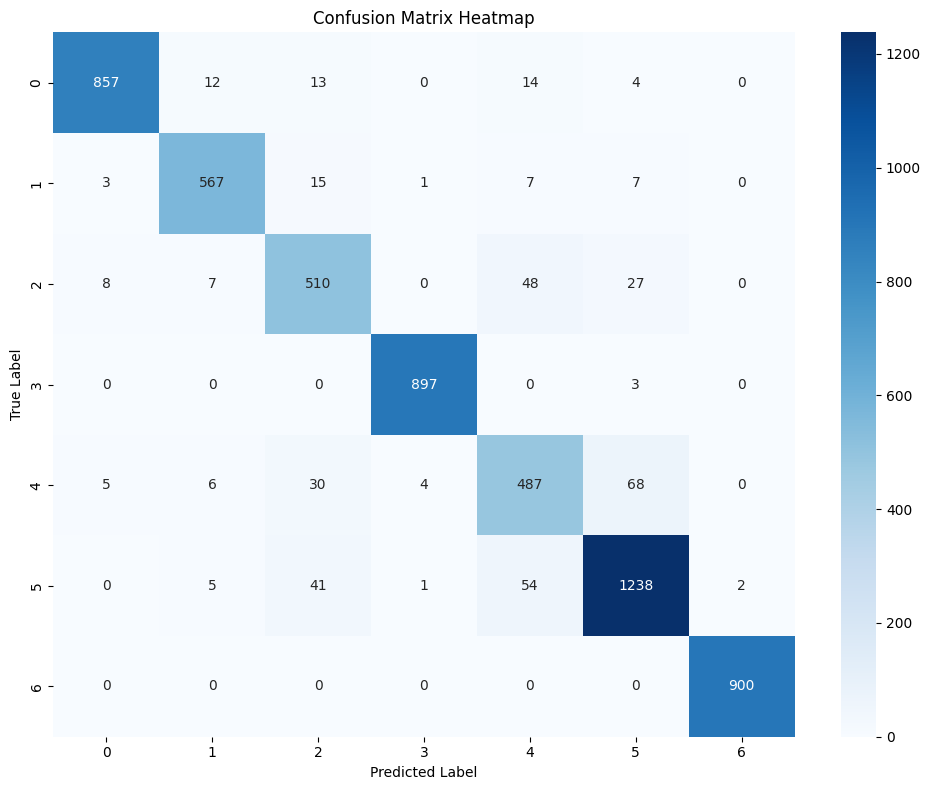

🎯 F1 Scores:
  Macro F1-score:   0.9254
  Micro F1-score:   0.9341
  Weighted F1-score:0.9343


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score
)

# === 1. Get Predictions from the Model ===
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# === 2. Class Labels ===
class_labels = list(test_generator.class_indices.keys())

# === 3. Classification Report ===
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# === 4. Overall Accuracy ===
acc = accuracy_score(y_true, y_pred_classes)
print(f"✅ Overall Accuracy: {acc:.4f}")

# === 5. Per-Class Accuracy ===
print("📌 Per-Class Accuracy:")
cm = confusion_matrix(y_true, y_pred_classes)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)
for i, label in enumerate(class_labels):
    print(f"  {label}: {class_wise_acc[i]:.4f}")

# === 6. Confusion Matrix Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === 7. F1-Scores ===
print("🎯 F1 Scores:")
print(f"  Macro F1-score:   {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"  Micro F1-score:   {f1_score(y_true, y_pred_classes, average='micro'):.4f}")
print(f"  Weighted F1-score:{f1_score(y_true, y_pred_classes, average='weighted'):.4f}")


In [26]:
# === 7. PARAMETERS ===
IMG_SIZE = 224
BATCH_SIZE = 32

# ✅ REMOVE RARE CLASSES BEFORE ENCODING
# Count each class
label_counts = combined_df['label'].value_counts()

# Filter out classes with less than 2 samples (if needed)
valid_labels = label_counts[label_counts >= 2].index
combined_df = combined_df[combined_df['label'].isin(valid_labels)].reset_index(drop=True)

# ✅ NOW Encode Labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])

# ✅ Stratified Split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

# ✅ Convert labels to strings for ImageDataGenerator with class_mode='sparse'
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# === 8. DATA GENERATORS ===
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse'  # ⬅️ Use 'raw' instead of 'sparse'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # ⬅️ Use 'raw' instead of 'sparse'
    shuffle=False
)



Found 26164 validated image filenames belonging to 7 classes.
Found 6541 validated image filenames belonging to 7 classes.


In [27]:
# === 5. Compute Class Weights ===
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.8494805194805195), 1: np.float64(1.3348979591836734), 2: np.float64(1.3348979591836734), 3: np.float64(0.9344285714285714), 4: np.float64(1.3348979591836734), 5: np.float64(0.6968147437946096), 6: np.float64(0.9344285714285714)}


In [33]:
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# === DenseNet169 MODEL ===
base_model = DenseNet169(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# ✅ Freeze most of the base model layers (fine-tune only top ones)
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

# ✅ Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(len(le.classes_), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ✅ Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Callbacks ===
callbacks = [
    ModelCheckpoint("best_densenet169.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1)
]

# ✅ Train the model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights
)

from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(
    'best_model1.h5',              # File to save model to
    monitor='val_accuracy',       # Metric to monitor
    save_best_only=True,          # Only save best model (not every epoch)
    mode='max',                   # Higher val_accuracy = better
    verbose=1
)
loss, acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {acc:.4f}")


51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 14s 0us/step
Epoch 1/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4022 - loss: 1.6722
Epoch 1: val_accuracy improved from -inf to 0.72984, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1140s 2s/step - accuracy: 0.4024 - loss: 1.6718 - val_accuracy: 0.7298 - val_loss: 0.7255 - learning_rate: 1.0000e-04
Epoch 2/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6772 - loss: 0.9366
Epoch 2: val_accuracy improved from 0.72984 to 0.79781, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1127s 2s/step - accuracy: 0.6772 - loss: 0.9365 - val_accuracy: 0.7978 - val_loss: 0.5561 - learning_rate: 1.0000e-04
Epoch 3/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7649 - loss: 0.7030
Epoch 3: val_accuracy improved from 0.79781 to 0.82280, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1136s 2s/step - accuracy: 0.7649 - loss: 0.7029 - val_accuracy: 0.8228 - val_loss: 0.4797 - learning_rate: 1.0000e-04
Epoch 4/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8016 - loss: 0.5858
Epoch 4: val_accuracy improved from 0.82280 to 0.85636, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1124s 2s/step - accuracy: 0.8016 - loss: 0.5858 - val_accuracy: 0.8564 - val_loss: 0.3962 - learning_rate: 1.0000e-04
Epoch 5/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8300 - loss: 0.5025
Epoch 5: val_accuracy did not improve from 0.85636
731/731 ━━━━━━━━━━━━━━━━━━━━ 1130s 2s/step - accuracy: 0.8300 - loss: 0.5025 - val_accuracy: 0.8411 - val_loss: 0.4269 - learning_rate: 1.0000e-04
Epoch 6/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8434 - loss: 0.4543
Epoch 6: val_accuracy improved from 0.85636 to 0.87964, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1161s 2s/step - accuracy: 0.8434 - loss: 0.4543 - val_accuracy: 0.8796 - val_loss: 0.3286 - learning_rate: 1.0000e-04
Epoch 7/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8624 - loss: 0.4076
Epoch 7: val_accuracy improved from 0.87964 to 0.88889, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1198s 2s/step - accuracy: 0.8624 - loss: 0.4075 - val_accuracy: 0.8889 - val_loss: 0.3066 - learning_rate: 1.0000e-04
Epoch 8/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8686 - loss: 0.3810
Epoch 8: val_accuracy improved from 0.88889 to 0.88906, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1123s 2s/step - accuracy: 0.8686 - loss: 0.3810 - val_accuracy: 0.8891 - val_loss: 0.3038 - learning_rate: 1.0000e-04
Epoch 9/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8870 - loss: 0.3422
Epoch 9: val_accuracy improved from 0.88906 to 0.90721, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1149s 2s/step - accuracy: 0.8870 - loss: 0.3422 - val_accuracy: 0.9072 - val_loss: 0.2526 - learning_rate: 1.0000e-04
Epoch 10/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8966 - loss: 0.3046
Epoch 10: val_accuracy did not improve from 0.90721
731/731 ━━━━━━━━━━━━━━━━━━━━ 1193s 2s/step - accuracy: 0.8966 - loss: 0.3046 - val_accuracy: 0.9043 - val_loss: 0.2725 - learning_rate: 1.0000e-04
Epoch 11/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8993 - loss: 0.2912
Epoch 11: val_accuracy improved from 0.90721 to 0.91731, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1195s 2s/step - accuracy: 0.8993 - loss: 0.2912 - val_accuracy: 0.9173 - val_loss: 0.2295 - learning_rate: 1.0000e-04
Epoch 12/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9088 - loss: 0.2611
Epoch 12: val_accuracy did not improve from 0.91731
731/731 ━━━━━━━━━━━━━━━━━━━━ 1220s 2s/step - accuracy: 0.9088 - loss: 0.2611 - val_accuracy: 0.9041 - val_loss: 0.2704 - learning_rate: 1.0000e-04
Epoch 13/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9151 - loss: 0.2471
Epoch 13: val_accuracy did not improve from 0.91731

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
731/731 ━━━━━━━━━━━━━━━━━━━━ 1198s 2s/step - accuracy: 0.9151 - loss: 0.2471 - val_accuracy: 0.9139 - val_loss: 0.2406 - learning_rate: 1.0000e-04
Epoch 14/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9288 - loss: 0.2098
Epoch 14: val_accuracy improved from 0.91731 to 0.93066, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1183s 2s/step - accuracy: 0.9288 - loss: 0.2097 - val_accuracy: 0.9307 - val_loss: 0.1977 - learning_rate: 3.0000e-05
Epoch 15/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9315 - loss: 0.1961
Epoch 15: val_accuracy improved from 0.93066 to 0.93237, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1268s 2s/step - accuracy: 0.9315 - loss: 0.1961 - val_accuracy: 0.9324 - val_loss: 0.1858 - learning_rate: 3.0000e-05
Epoch 16/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9379 - loss: 0.1778
Epoch 16: val_accuracy improved from 0.93237 to 0.93443, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1301s 2s/step - accuracy: 0.9379 - loss: 0.1778 - val_accuracy: 0.9344 - val_loss: 0.1888 - learning_rate: 3.0000e-05
Epoch 17/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9369 - loss: 0.1754
Epoch 17: val_accuracy did not improve from 0.93443

Epoch 17: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.
731/731 ━━━━━━━━━━━━━━━━━━━━ 1287s 2s/step - accuracy: 0.9369 - loss: 0.1754 - val_accuracy: 0.9322 - val_loss: 0.1976 - learning_rate: 3.0000e-05
Epoch 18/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9413 - loss: 0.1627
Epoch 18: val_accuracy improved from 0.93443 to 0.93460, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1202s 2s/step - accuracy: 0.9413 - loss: 0.1627 - val_accuracy: 0.9346 - val_loss: 0.1847 - learning_rate: 9.0000e-06
Epoch 19/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9426 - loss: 0.1596
Epoch 19: val_accuracy improved from 0.93460 to 0.93477, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1267s 2s/step - accuracy: 0.9426 - loss: 0.1596 - val_accuracy: 0.9348 - val_loss: 0.1853 - learning_rate: 9.0000e-06
Epoch 20/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9463 - loss: 0.1525
Epoch 20: val_accuracy improved from 0.93477 to 0.93768, saving model to best_densenet169.h5


731/731 ━━━━━━━━━━━━━━━━━━━━ 1170s 2s/step - accuracy: 0.9463 - loss: 0.1525 - val_accuracy: 0.9377 - val_loss: 0.1837 - learning_rate: 9.0000e-06
Epoch 21/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9490 - loss: 0.1441
Epoch 21: val_accuracy did not improve from 0.93768
731/731 ━━━━━━━━━━━━━━━━━━━━ 1158s 2s/step - accuracy: 0.9490 - loss: 0.1441 - val_accuracy: 0.9349 - val_loss: 0.1906 - learning_rate: 9.0000e-06
Epoch 22/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9493 - loss: 0.1418
Epoch 22: val_accuracy did not improve from 0.93768

Epoch 22: ReduceLROnPlateau reducing learning rate to 2.6999998226528985e-06.
731/731 ━━━━━━━━━━━━━━━━━━━━ 1165s 2s/step - accuracy: 0.9493 - loss: 0.1418 - val_accuracy: 0.9353 - val_loss: 0.1852 - learning_rate: 9.0000e-06
Epoch 23/25
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9480 - loss: 0.1457
Epoch 23: val_accuracy did not improve from 0.93768
731/731 ━━━━━━━━━━━━━━━━━━━━ 1216s 2s/step - accuracy: 0.9480 - lo

183/183 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       900
           1       0.97      0.96      0.96       600
           2       0.84      0.85      0.84       600
           3       0.99      1.00      1.00       900
           4       0.84      0.81      0.82       600
           5       0.90      0.94      0.92      1341
           6       1.00      1.00      1.00       900

    accuracy                           0.94      5841
   macro avg       0.93      0.93      0.93      5841
weighted avg       0.94      0.94      0.94      5841

✅ Overall Accuracy: 0.9372
📌 Per-Class Accuracy:
  0: 0.9522
  1: 0.9567
  2: 0.8483
  3: 0.9989
  4: 0.8050
  5: 0.9359
  6: 0.9967


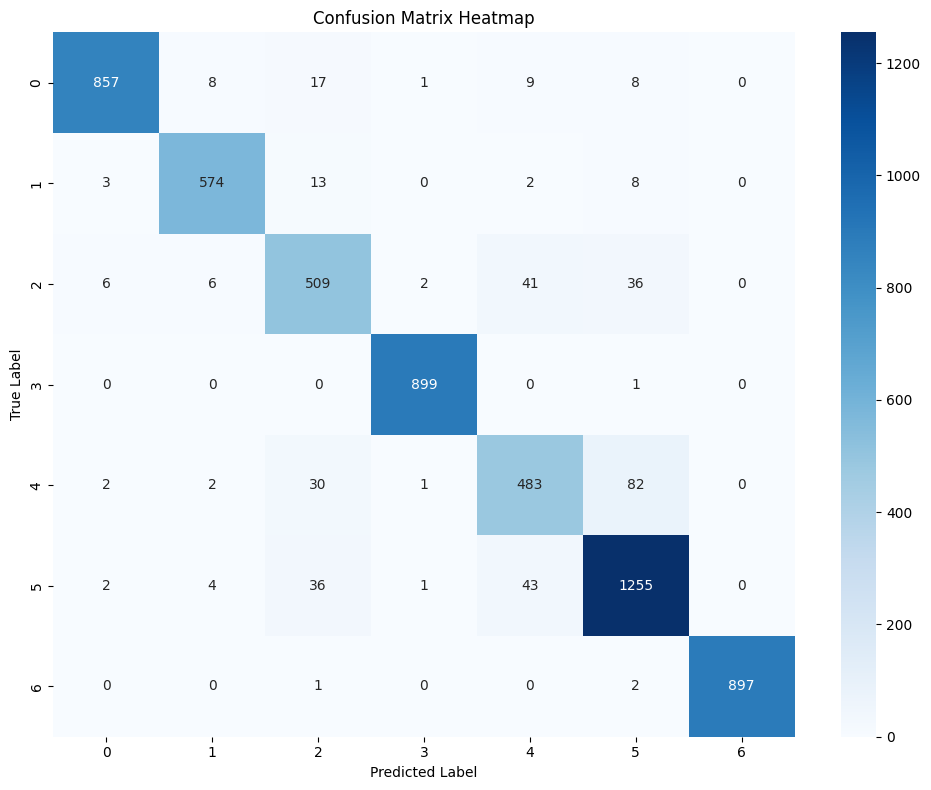

🎯 F1 Scores:
  Macro F1-score:   0.9296
  Micro F1-score:   0.9372
  Weighted F1-score:0.9372


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score
)

# === 1. Get Predictions from the Model ===
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# === 2. Class Labels ===
class_labels = list(test_generator.class_indices.keys())

# === 3. Classification Report ===
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# === 4. Overall Accuracy ===
acc = accuracy_score(y_true, y_pred_classes)
print(f"✅ Overall Accuracy: {acc:.4f}")

# === 5. Per-Class Accuracy ===
print("📌 Per-Class Accuracy:")
cm = confusion_matrix(y_true, y_pred_classes)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)
for i, label in enumerate(class_labels):
    print(f"  {label}: {class_wise_acc[i]:.4f}")

# === 6. Confusion Matrix Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === 7. F1-Scores ===
print("🎯 F1 Scores:")
print(f"  Macro F1-score:   {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"  Micro F1-score:   {f1_score(y_true, y_pred_classes, average='micro'):.4f}")
print(f"  Weighted F1-score:{f1_score(y_true, y_pred_classes, average='weighted'):.4f}")


In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# === Simple CNN Model ===
simple_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')  # Number of output classes
])

# === Compile ===
simple_cnn.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# === Train ===
history = simple_cnn.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=callbacks,        # Use your earlier callbacks (EarlyStopping, etc.)
    class_weight=class_weights  # If you have class imbalance
)


C:\Users\Asus\anaconda3\envs\ham10000_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 543ms/step - accuracy: 0.3066 - loss: 1.7636
Epoch 1: val_accuracy did not improve from 0.93768
731/731 ━━━━━━━━━━━━━━━━━━━━ 423s 578ms/step - accuracy: 0.3067 - loss: 1.7634 - val_accuracy: 0.5256 - val_loss: 1.2124 - learning_rate: 1.0000e-04
Epoch 2/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.4797 - loss: 1.3616
Epoch 2: val_accuracy did not improve from 0.93768
731/731 ━━━━━━━━━━━━━━━━━━━━ 436s 596ms/step - accuracy: 0.4797 - loss: 1.3615 - val_accuracy: 0.5708 - val_loss: 1.1040 - learning_rate: 1.0000e-04
Epoch 3/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.5286 - loss: 1.2621
Epoch 3: val_accuracy did not improve from 0.93768
731/731 ━━━━━━━━━━━━━━━━━━━━ 428s 585ms/step - accuracy: 0.5286 - loss: 1.2621 - val_accuracy: 0.5978 - val_loss: 1.0749 - learning_rate: 1.0000e-04
Epoch 4/20
731/731 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - accuracy: 0.5413 - loss: 1.2244
Epoch 4: val_accuracy did not improve from 0.937

183/183 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       900
           1       0.97      0.96      0.96       600
           2       0.84      0.85      0.84       600
           3       0.99      1.00      1.00       900
           4       0.84      0.81      0.82       600
           5       0.90      0.94      0.92      1341
           6       1.00      1.00      1.00       900

    accuracy                           0.94      5841
   macro avg       0.93      0.93      0.93      5841
weighted avg       0.94      0.94      0.94      5841

✅ Overall Accuracy: 0.9372
📌 Per-Class Accuracy:
  0: 0.9522
  1: 0.9567
  2: 0.8483
  3: 0.9989
  4: 0.8050
  5: 0.9359
  6: 0.9967


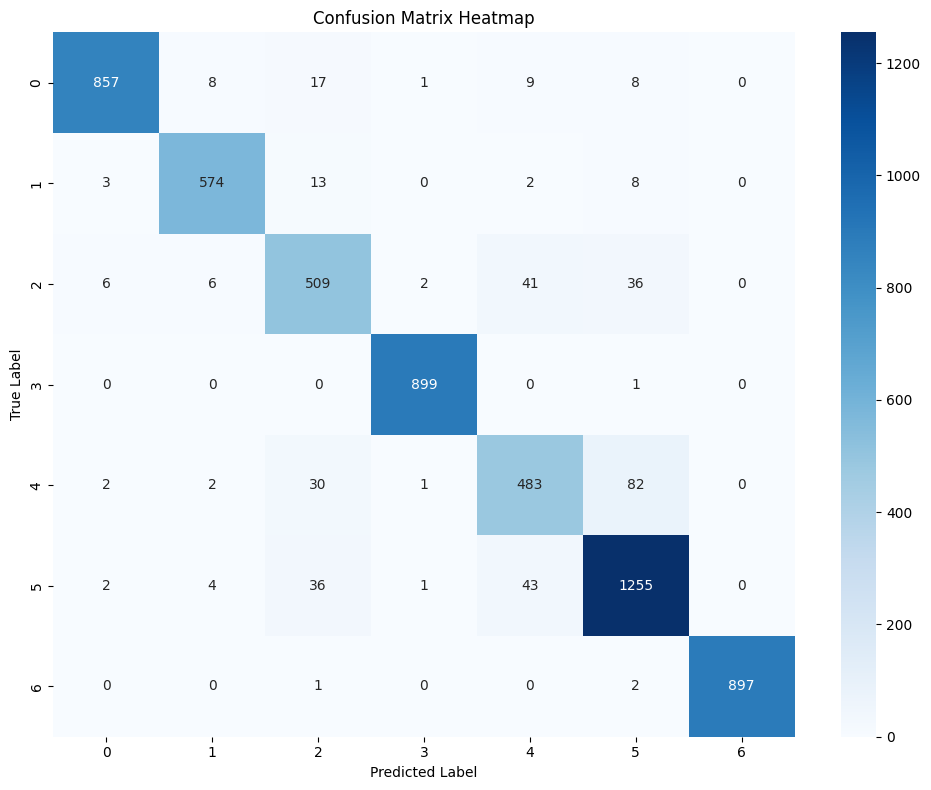

🎯 F1 Scores:
  Macro F1-score:   0.9296
  Micro F1-score:   0.9372
  Weighted F1-score:0.9372


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score
)

# === 1. Get Predictions from the Model ===
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# === 2. Class Labels ===
class_labels = list(test_generator.class_indices.keys())

# === 3. Classification Report ===
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# === 4. Overall Accuracy ===
acc = accuracy_score(y_true, y_pred_classes)
print(f"✅ Overall Accuracy: {acc:.4f}")

# === 5. Per-Class Accuracy ===
print("📌 Per-Class Accuracy:")
cm = confusion_matrix(y_true, y_pred_classes)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)
for i, label in enumerate(class_labels):
    print(f"  {label}: {class_wise_acc[i]:.4f}")

# === 6. Confusion Matrix Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === 7. F1-Scores ===
print("🎯 F1 Scores:")
print(f"  Macro F1-score:   {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"  Micro F1-score:   {f1_score(y_true, y_pred_classes, average='micro'):.4f}")
print(f"  Weighted F1-score:{f1_score(y_true, y_pred_classes, average='weighted'):.4f}")


In [30]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D, Dense, concatenate
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# === Parameters ===
IMG_SIZE = 224
LEARNING_RATE = 1e-4
DROPOUT_RATE = 0.5
NUM_CLASSES = len(le.classes_)  # You can replace with 7 if fixed

# === Input Layer ===
input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# === CNN Branch (Shallow Features) ===
cnn = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)

cnn = Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
cnn = MaxPooling2D((2, 2))(cnn)
cnn = Dropout(0.3)(cnn)

cnn = GlobalAveragePooling2D()(cnn)

# === DenseNet121 Branch (Deep Features) ===
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
densenet_base.trainable = True
for layer in densenet_base.layers[:-30]:
    layer.trainable = False

dense = densenet_base.output
dense = GlobalAveragePooling2D()(dense)
dense = Dropout(DROPOUT_RATE)(dense)

# === Merge CNN + DenseNet Branches ===
merged = concatenate([cnn, dense])

# === Classification Head ===
x = Dense(256, activation='relu')(merged)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

# === Final Model ===
model = Model(inputs=input_tensor, outputs=output)

# === Compile Model ===
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
]
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=callbacks,
    class_weight=class_weights
)

# === Summary (Optional) ===
model.summary()


C:\Users\Asus\anaconda3\envs\ham10000_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3863 - loss: 1.7702
Epoch 1: val_accuracy improved from -inf to 0.71809, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1289s 2s/step - accuracy: 0.3864 - loss: 1.7698 - val_accuracy: 0.7181 - val_loss: 0.7952 - learning_rate: 1.0000e-04
Epoch 2/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6538 - loss: 0.9994
Epoch 2: val_accuracy improved from 0.71809 to 0.79116, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1259s 2s/step - accuracy: 0.6538 - loss: 0.9993 - val_accuracy: 0.7912 - val_loss: 0.5853 - learning_rate: 1.0000e-04
Epoch 3/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7296 - loss: 0.7813
Epoch 3: val_accuracy improved from 0.79116 to 0.81700, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1260s 2s/step - accuracy: 0.7296 - loss: 0.7813 - val_accuracy: 0.8170 - val_loss: 0.4848 - learning_rate: 1.0000e-04
Epoch 4/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7695 - loss: 0.6653
Epoch 4: val_accuracy improved from 0.81700 to 0.84207, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1262s 2s/step - accuracy: 0.7695 - loss: 0.6653 - val_accuracy: 0.8421 - val_loss: 0.4220 - learning_rate: 1.0000e-04
Epoch 5/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8083 - loss: 0.5636
Epoch 5: val_accuracy improved from 0.84207 to 0.85323, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1269s 2s/step - accuracy: 0.8083 - loss: 0.5636 - val_accuracy: 0.8532 - val_loss: 0.3977 - learning_rate: 1.0000e-04
Epoch 6/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8302 - loss: 0.5043
Epoch 6: val_accuracy improved from 0.85323 to 0.87143, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1267s 2s/step - accuracy: 0.8302 - loss: 0.5043 - val_accuracy: 0.8714 - val_loss: 0.3513 - learning_rate: 1.0000e-04
Epoch 7/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8522 - loss: 0.4397
Epoch 7: val_accuracy improved from 0.87143 to 0.88152, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1272s 2s/step - accuracy: 0.8522 - loss: 0.4396 - val_accuracy: 0.8815 - val_loss: 0.3206 - learning_rate: 1.0000e-04
Epoch 8/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8659 - loss: 0.4003
Epoch 8: val_accuracy improved from 0.88152 to 0.89421, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1268s 2s/step - accuracy: 0.8659 - loss: 0.4003 - val_accuracy: 0.8942 - val_loss: 0.2839 - learning_rate: 1.0000e-04
Epoch 9/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8794 - loss: 0.3604
Epoch 9: val_accuracy did not improve from 0.89421
818/818 ━━━━━━━━━━━━━━━━━━━━ 1269s 2s/step - accuracy: 0.8794 - loss: 0.3604 - val_accuracy: 0.8907 - val_loss: 0.3052 - learning_rate: 1.0000e-04
Epoch 10/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8849 - loss: 0.3409
Epoch 10: val_accuracy improved from 0.89421 to 0.89879, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1291s 2s/step - accuracy: 0.8849 - loss: 0.3409 - val_accuracy: 0.8988 - val_loss: 0.2818 - learning_rate: 1.0000e-04
Epoch 11/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8994 - loss: 0.2972
Epoch 11: val_accuracy improved from 0.89879 to 0.91163, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1264s 2s/step - accuracy: 0.8994 - loss: 0.2972 - val_accuracy: 0.9116 - val_loss: 0.2467 - learning_rate: 1.0000e-04
Epoch 12/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9022 - loss: 0.2855
Epoch 12: val_accuracy did not improve from 0.91163
818/818 ━━━━━━━━━━━━━━━━━━━━ 1261s 2s/step - accuracy: 0.9022 - loss: 0.2855 - val_accuracy: 0.9100 - val_loss: 0.2451 - learning_rate: 1.0000e-04
Epoch 13/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9116 - loss: 0.2644
Epoch 13: val_accuracy improved from 0.91163 to 0.92172, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1306s 2s/step - accuracy: 0.9116 - loss: 0.2644 - val_accuracy: 0.9217 - val_loss: 0.2079 - learning_rate: 1.0000e-04
Epoch 14/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9153 - loss: 0.2466
Epoch 14: val_accuracy did not improve from 0.92172
818/818 ━━━━━━━━━━━━━━━━━━━━ 1318s 2s/step - accuracy: 0.9153 - loss: 0.2466 - val_accuracy: 0.9041 - val_loss: 0.2688 - learning_rate: 1.0000e-04
Epoch 15/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9214 - loss: 0.2363
Epoch 15: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.

Epoch 15: val_accuracy improved from 0.92172 to 0.92478, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1311s 2s/step - accuracy: 0.9214 - loss: 0.2363 - val_accuracy: 0.9248 - val_loss: 0.2106 - learning_rate: 1.0000e-04
Epoch 16/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9324 - loss: 0.2014
Epoch 16: val_accuracy improved from 0.92478 to 0.92601, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1291s 2s/step - accuracy: 0.9324 - loss: 0.2014 - val_accuracy: 0.9260 - val_loss: 0.2026 - learning_rate: 3.0000e-05
Epoch 17/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9349 - loss: 0.1925
Epoch 17: val_accuracy improved from 0.92601 to 0.93426, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1281s 2s/step - accuracy: 0.9349 - loss: 0.1925 - val_accuracy: 0.9343 - val_loss: 0.1798 - learning_rate: 3.0000e-05
Epoch 18/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9391 - loss: 0.1783
Epoch 18: val_accuracy improved from 0.93426 to 0.93732, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1277s 2s/step - accuracy: 0.9391 - loss: 0.1783 - val_accuracy: 0.9373 - val_loss: 0.1731 - learning_rate: 3.0000e-05
Epoch 19/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9450 - loss: 0.1664
Epoch 19: val_accuracy did not improve from 0.93732
818/818 ━━━━━━━━━━━━━━━━━━━━ 1281s 2s/step - accuracy: 0.9450 - loss: 0.1664 - val_accuracy: 0.9356 - val_loss: 0.1786 - learning_rate: 3.0000e-05
Epoch 20/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9436 - loss: 0.1637
Epoch 20: val_accuracy improved from 0.93732 to 0.93976, saving model to best_model.h5


818/818 ━━━━━━━━━━━━━━━━━━━━ 1283s 2s/step - accuracy: 0.9436 - loss: 0.1637 - val_accuracy: 0.9398 - val_loss: 0.1725 - learning_rate: 3.0000e-05
Epoch 21/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9449 - loss: 0.1636
Epoch 21: val_accuracy did not improve from 0.93976
818/818 ━━━━━━━━━━━━━━━━━━━━ 1284s 2s/step - accuracy: 0.9449 - loss: 0.1636 - val_accuracy: 0.9376 - val_loss: 0.1894 - learning_rate: 3.0000e-05
Epoch 22/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9433 - loss: 0.1614
Epoch 22: ReduceLROnPlateau reducing learning rate to 8.999999772640877e-06.

Epoch 22: val_accuracy did not improve from 0.93976
818/818 ━━━━━━━━━━━━━━━━━━━━ 1315s 2s/step - accuracy: 0.9433 - loss: 0.1614 - val_accuracy: 0.9381 - val_loss: 0.1760 - learning_rate: 3.0000e-05
Epoch 23/25
818/818 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9480 - loss: 0.1484
Epoch 23: val_accuracy did not improve from 0.93976
818/818 ━━━━━━━━━━━━━━━━━━━━ 1746s 2s/step - accuracy: 0.9480 - los

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 224, 224, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_4              │ (None, 230, 230, 3)       │               0 │ input_layer_2[0][0]        │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 112, 112, 64)      │           9,408 │ zero_padding2d_4[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 112, 112, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 112, 112, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_5              │ (None, 114, 114, 64)      │               0 │ conv1_relu[0][0]           │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1 (MaxPooling2D)          │ (None, 56, 56, 64)        │               0 │ zero_padding2d_5[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_bn             │ (None, 56, 56, 64)        │             256 │ pool1[0][0]                │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_relu           │ (None, 56, 56, 64)        │               0 │ conv2_block1_0_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 56, 56, 128)       │           8,192 │ conv2_block1_0_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 56, 56, 128)       │             512 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 56, 56, 128)       │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 56, 56, 32)        │          36,864 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_concat           │ (None, 56, 56, 96)        │               0 │ pool1[0][0],               │
│ (Concatenate)                 │                           │               

 Total params: 9,220,247 (35.17 MB)

 Trainable params: 941,383 (3.59 MB)

 Non-trainable params: 6,396,096 (24.40 MB)

 Optimizer params: 1,882,768 (7.18 MB)

205/205 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step
🔍 Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1100
           1       0.98      0.93      0.96       700
           2       0.81      0.87      0.84       700
           3       1.00      1.00      1.00      1000
           4       0.84      0.82      0.83       700
           5       0.90      0.93      0.92      1341
           6       1.00      1.00      1.00      1000

    accuracy                           0.94      6541
   macro avg       0.93      0.93      0.93      6541
weighted avg       0.94      0.94      0.94      6541

✅ Overall Accuracy: 0.9379
📌 Per-Class Accuracy:
  0: 0.9509
  1: 0.9314
  2: 0.8714
  3: 0.9980
  4: 0.8229
  5: 0.9344
  6: 1.0000


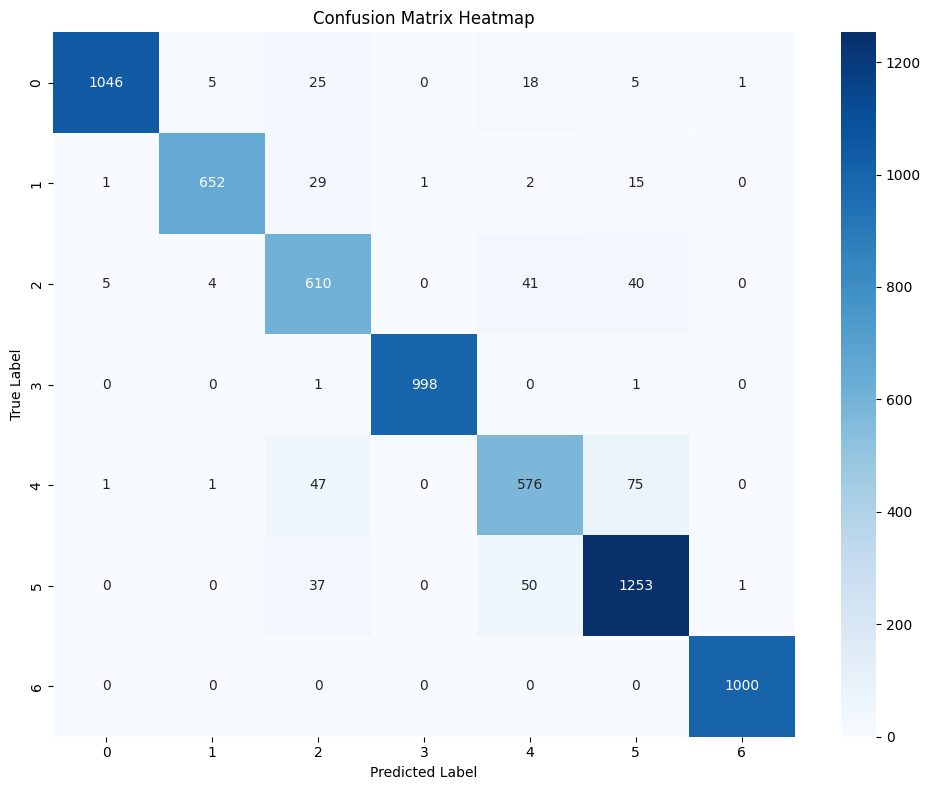

🎯 F1 Scores:
  Macro F1-score:   0.9310
  Micro F1-score:   0.9379
  Weighted F1-score:0.9384


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score
)

# === 1. Get Predictions from the Model ===
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

# === 2. Class Labels ===
class_labels = list(test_generator.class_indices.keys())

# === 3. Classification Report ===
print("🔍 Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# === 4. Overall Accuracy ===
acc = accuracy_score(y_true, y_pred_classes)
print(f"✅ Overall Accuracy: {acc:.4f}")

# === 5. Per-Class Accuracy ===
print("📌 Per-Class Accuracy:")
cm = confusion_matrix(y_true, y_pred_classes)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)
for i, label in enumerate(class_labels):
    print(f"  {label}: {class_wise_acc[i]:.4f}")

# === 6. Confusion Matrix Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === 7. F1-Scores ===
print("🎯 F1 Scores:")
print(f"  Macro F1-score:   {f1_score(y_true, y_pred_classes, average='macro'):.4f}")
print(f"  Micro F1-score:   {f1_score(y_true, y_pred_classes, average='micro'):.4f}")
print(f"  Weighted F1-score:{f1_score(y_true, y_pred_classes, average='weighted'):.4f}")


In [47]:
# Count each class
label_counts = combined_df['label'].value_counts()

# Remove classes with fewer than 2 samples
# Remove classes with fewer than 2 samples
valid_labels = label_counts[label_counts >= 2].index
combined_df = combined_df[combined_df['label'].isin(valid_labels)].reset_index(drop=True)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])


In [51]:
# Step 0: Remove rare classes (e.g., classes with < 2 samples)
label_counts = combined_df['label'].value_counts()
combined_df = combined_df[combined_df['label'].isin(label_counts[label_counts >= 2].index)].reset_index(drop=True)

# Step 1: Label encode
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])

# Step 2: Split
train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

# Step 3: Convert to string
train_df['label'] = train_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

# Confirm
print("Classes:", le.classes_)
print("Train labels:", train_df['label'].unique())
print("Label type:", train_df['label'].apply(type).unique())


Classes: [0 1 2 3 4]
Train labels: ['4' '3' '1' '2' '0']
Label type: [<class 'str'>]


In [30]:
IMG_SIZE = 224  
BATCH_SIZE = 16

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np

# Filter rare labels (<2 samples)
label_counts = combined_df['label'].value_counts()
valid_labels = label_counts[label_counts >= 2].index
combined_df = combined_df[combined_df['label'].isin(valid_labels)].reset_index(drop=True)

# Encode labels
le = LabelEncoder()
combined_df['label'] = le.fit_transform(combined_df['label'])

train_df, test_df = train_test_split(
    combined_df,
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label']
)
class_weights = dict(enumerate(class_weights))

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    shear_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='raw',
    shuffle=False
)



Found 14964 validated image filenames.
Found 3741 validated image filenames.


In [32]:
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import DenseNet121, EfficientNetB3
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

input_tensor = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# DenseNet121 branch
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in densenet_base.layers[:-30]:
    layer.trainable = False
x1 = GlobalAveragePooling2D()(densenet_base.output)

# EfficientNetB3 branch
efficientnet_base = EfficientNetB3(weights='imagenet', include_top=False, input_tensor=input_tensor)
for layer in efficientnet_base.layers[:-30]:
    layer.trainable = False
x2 = GlobalAveragePooling2D()(efficientnet_base.output)

# Combine both
merged = Concatenate()([x1, x2])
merged = Dropout(0.5)(merged)
merged = Dense(512, activation='relu')(merged)
merged = Dropout(0.3)(merged)
output = Dense(len(le.classes_), activation='softmax')(merged)

model = Model(inputs=input_tensor, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    ModelCheckpoint("best_hybrid_model.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1),
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1)
]

history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    class_weight=class_weights,
    callbacks=callbacks
)
model.save("hybrid_densenet_efficientnet_model.h5")

C:\Users\Asus\anaconda3\envs\ham10000_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3759 - loss: 1.7372
Epoch 1: val_accuracy improved from -inf to 0.70115, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1243s 1s/step - accuracy: 0.3760 - loss: 1.7369 - val_accuracy: 0.7011 - val_loss: 0.8007 - learning_rate: 1.0000e-04
Epoch 2/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6163 - loss: 1.1049
Epoch 2: val_accuracy improved from 0.70115 to 0.75381, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1197s 1s/step - accuracy: 0.6163 - loss: 1.1049 - val_accuracy: 0.7538 - val_loss: 0.6635 - learning_rate: 1.0000e-04
Epoch 3/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6698 - loss: 0.9331
Epoch 3: val_accuracy did not improve from 0.75381
936/936 ━━━━━━━━━━━━━━━━━━━━ 1206s 1s/step - accuracy: 0.6698 - loss: 0.9331 - val_accuracy: 0.7519 - val_loss: 0.6397 - learning_rate: 1.0000e-04
Epoch 4/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7004 - loss: 0.8059
Epoch 4: val_accuracy improved from 0.75381 to 0.79497, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1158s 1s/step - accuracy: 0.7004 - loss: 0.8059 - val_accuracy: 0.7950 - val_loss: 0.5301 - learning_rate: 1.0000e-04
Epoch 5/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7222 - loss: 0.7571
Epoch 5: val_accuracy improved from 0.79497 to 0.80593, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1147s 1s/step - accuracy: 0.7222 - loss: 0.7571 - val_accuracy: 0.8059 - val_loss: 0.5363 - learning_rate: 1.0000e-04
Epoch 6/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7440 - loss: 0.6893
Epoch 6: val_accuracy did not improve from 0.80593
936/936 ━━━━━━━━━━━━━━━━━━━━ 1146s 1s/step - accuracy: 0.7440 - loss: 0.6893 - val_accuracy: 0.8051 - val_loss: 0.4983 - learning_rate: 1.0000e-04
Epoch 7/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7482 - loss: 0.6552
Epoch 7: val_accuracy did not improve from 0.80593
936/936 ━━━━━━━━━━━━━━━━━━━━ 1144s 1s/step - accuracy: 0.7482 - loss: 0.6552 - val_accuracy: 0.8014 - val_loss: 0.5215 - learning_rate: 1.0000e-04
Epoch 8/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7699 - loss: 0.6155
Epoch 8: val_accuracy did not improve from 0.80593
936/936 ━━━━━━━━━━━━━━━━━━━━ 1170s 1s/step - accuracy: 0.7699 - loss: 0.6155 - val_accuracy: 0.8019 - val_loss: 0.4934 - learning_rate: 1.0000e-04
Epoc

936/936 ━━━━━━━━━━━━━━━━━━━━ 1196s 1s/step - accuracy: 0.7759 - loss: 0.5619 - val_accuracy: 0.8474 - val_loss: 0.4200 - learning_rate: 1.0000e-04
Epoch 10/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7917 - loss: 0.5420
Epoch 10: val_accuracy did not improve from 0.84737
936/936 ━━━━━━━━━━━━━━━━━━━━ 1185s 1s/step - accuracy: 0.7917 - loss: 0.5420 - val_accuracy: 0.8466 - val_loss: 0.4136 - learning_rate: 1.0000e-04
Epoch 11/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7954 - loss: 0.5137
Epoch 11: val_accuracy did not improve from 0.84737
936/936 ━━━━━━━━━━━━━━━━━━━━ 1210s 1s/step - accuracy: 0.7954 - loss: 0.5137 - val_accuracy: 0.8182 - val_loss: 0.4636 - learning_rate: 1.0000e-04
Epoch 12/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8066 - loss: 0.4875
Epoch 12: val_accuracy improved from 0.84737 to 0.85191, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1238s 1s/step - accuracy: 0.8066 - loss: 0.4875 - val_accuracy: 0.8519 - val_loss: 0.3861 - learning_rate: 1.0000e-04
Epoch 13/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8113 - loss: 0.4637
Epoch 13: val_accuracy did not improve from 0.85191
936/936 ━━━━━━━━━━━━━━━━━━━━ 1171s 1s/step - accuracy: 0.8113 - loss: 0.4638 - val_accuracy: 0.8287 - val_loss: 0.4506 - learning_rate: 1.0000e-04
Epoch 14/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8181 - loss: 0.4527
Epoch 14: val_accuracy improved from 0.85191 to 0.85512, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1235s 1s/step - accuracy: 0.8181 - loss: 0.4527 - val_accuracy: 0.8551 - val_loss: 0.3824 - learning_rate: 1.0000e-04
Epoch 15/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8255 - loss: 0.4341
Epoch 15: val_accuracy improved from 0.85512 to 0.85726, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1251s 1s/step - accuracy: 0.8255 - loss: 0.4341 - val_accuracy: 0.8573 - val_loss: 0.3941 - learning_rate: 1.0000e-04
Epoch 16/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8387 - loss: 0.4080
Epoch 16: val_accuracy improved from 0.85726 to 0.86982, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1213s 1s/step - accuracy: 0.8387 - loss: 0.4080 - val_accuracy: 0.8698 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 17/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8354 - loss: 0.4128
Epoch 17: val_accuracy did not improve from 0.86982
936/936 ━━━━━━━━━━━━━━━━━━━━ 1236s 1s/step - accuracy: 0.8354 - loss: 0.4128 - val_accuracy: 0.8511 - val_loss: 0.4045 - learning_rate: 1.0000e-04
Epoch 18/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8426 - loss: 0.4020
Epoch 18: val_accuracy did not improve from 0.86982
936/936 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.8426 - loss: 0.4020 - val_accuracy: 0.8570 - val_loss: 0.3941 - learning_rate: 1.0000e-04
Epoch 19/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8476 - loss: 0.3680
Epoch 19: val_accuracy did not improve from 0.86982

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
936/936 ━━━━━━━━━━━━━━━━━━━━ 1217s 1s/step - accuracy: 0.8476 - lo

936/936 ━━━━━━━━━━━━━━━━━━━━ 1176s 1s/step - accuracy: 0.8688 - loss: 0.3215 - val_accuracy: 0.8728 - val_loss: 0.3461 - learning_rate: 3.0000e-05
Epoch 22/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8698 - loss: 0.3104
Epoch 22: val_accuracy did not improve from 0.87276
936/936 ━━━━━━━━━━━━━━━━━━━━ 1190s 1s/step - accuracy: 0.8698 - loss: 0.3104 - val_accuracy: 0.8669 - val_loss: 0.3573 - learning_rate: 3.0000e-05
Epoch 23/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8722 - loss: 0.3080
Epoch 23: val_accuracy improved from 0.87276 to 0.87784, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1163s 1s/step - accuracy: 0.8722 - loss: 0.3080 - val_accuracy: 0.8778 - val_loss: 0.3345 - learning_rate: 3.0000e-05
Epoch 24/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8741 - loss: 0.3014
Epoch 24: val_accuracy improved from 0.87784 to 0.87864, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1153s 1s/step - accuracy: 0.8741 - loss: 0.3014 - val_accuracy: 0.8786 - val_loss: 0.3420 - learning_rate: 3.0000e-05
Epoch 25/25
936/936 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8776 - loss: 0.3050
Epoch 25: val_accuracy improved from 0.87864 to 0.88265, saving model to best_hybrid_model.h5


936/936 ━━━━━━━━━━━━━━━━━━━━ 1154s 1s/step - accuracy: 0.8776 - loss: 0.3050 - val_accuracy: 0.8827 - val_loss: 0.3278 - learning_rate: 3.0000e-05
Restoring model weights from the end of the best epoch: 25.


🔍 Generating predictions...
234/234 ━━━━━━━━━━━━━━━━━━━━ 226s 966ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       400
           1       0.90      0.90      0.90       400
           2       0.71      0.79      0.74       400
           3       0.99      0.99      0.99       400
           4       0.66      0.73      0.69       400
           5       0.92      0.90      0.91      1341
           6       1.00      1.00      1.00       400

    accuracy                           0.88      3741
   macro avg       0.88      0.88      0.88      3741
weighted avg       0.89      0.88      0.88      3741


✅ Overall Accuracy: 0.8827

📌 Per-Class Accuracy:
  0: 0.8325
  1: 0.9000
  2: 0.7850
  3: 0.9925
  4: 0.7325
  5: 0.8986
  6: 1.0000


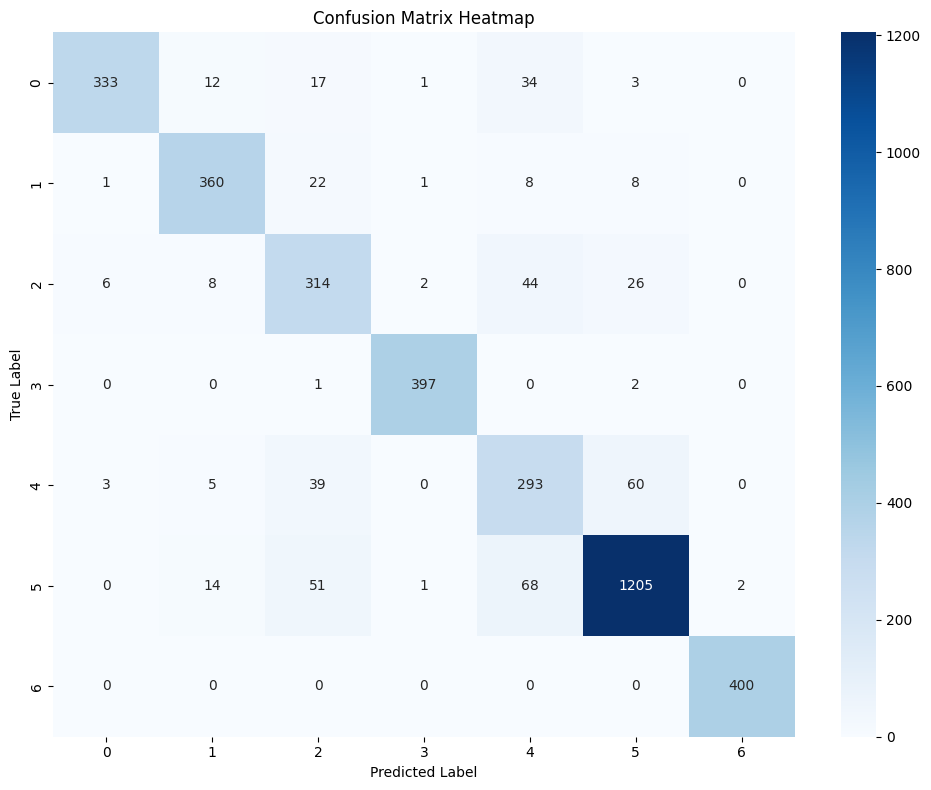


🎯 F1 Scores:
  Macro F1-score:   0.8760
  Micro F1-score:   0.8827
  Weighted F1-score:0.8849


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    f1_score
)

# === 1. Get Predictions from the Model ===
print("🔍 Generating predictions...")
y_pred_probs = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# === 2. True Labels ===
y_true = test_df['label'].astype(int).values

# === 3. Class Labels (ensure they are strings) ===
class_labels = [str(label) for label in le.classes_]

# === 4. Classification Report ===
print("\n📊 Classification Report:")
print(classification_report(
    y_true,
    y_pred_classes,
    target_names=class_labels,
    zero_division=0  # avoid errors if a class has 0 predicted samples
))

# === 5. Overall Accuracy ===
acc = accuracy_score(y_true, y_pred_classes)
print(f"\n✅ Overall Accuracy: {acc:.4f}")

# === 6. Per-Class Accuracy ===
cm = confusion_matrix(y_true, y_pred_classes)
class_wise_acc = cm.diagonal() / cm.sum(axis=1)
print("\n📌 Per-Class Accuracy:")
for i, label in enumerate(class_labels):
    print(f"  {label}: {class_wise_acc[i]:.4f}")

# === 7. Confusion Matrix Heatmap ===
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === 8. F1-Scores ===
macro_f1 = f1_score(y_true, y_pred_classes, average='macro')
micro_f1 = f1_score(y_true, y_pred_classes, average='micro')
weighted_f1 = f1_score(y_true, y_pred_classes, average='weighted')

print("\n🎯 F1 Scores:")
print(f"  Macro F1-score:   {macro_f1:.4f}")
print(f"  Micro F1-score:   {micro_f1:.4f}")
print(f"  Weighted F1-score:{weighted_f1:.4f}")
